In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# jax
import jax.numpy as jnp
from jax import random
import time

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

# interpolation
from scipy.interpolate import CubicSpline

# pre-processing
from sklearn.preprocessing import StandardScaler

# collocation
import sys
import os
p_ = os.path.abspath(os.path.join('..', '00_utils'))
if p_ not in sys.path:
    sys.path.append(p_)
    
p_ = os.path.abspath(os.path.join('..', '00_models'))
if p_ not in sys.path:
    sys.path.append(p_)

import preprocess # helper preprocessing class

from collocation import compute_weights, lagrange_derivative
from non_parametric_collocation import collocate_data

# pyomo
import importlib
import nn_pyomo_base
import nn_pyomo_base_dae

import statsmodels.api as sm
from scipy.ndimage import gaussian_filter1d

In [3]:
importlib.reload(preprocess)
DataPreprocessor = preprocess.DataPreprocessor

# , 'temperature': 'var1'
file_path = '../00_data/df_train.csv'
encoding = {'settlement_date': 't', 'temperature': 'var1', 'hour': 'var2', 'nd': 'y'}

data_loader = DataPreprocessor(file_path, start_date = '2015-01-10', number_of_points = 400, tau = 48, m = 1, feature_encoding = encoding, split=200)
data_subsample = data_loader.load_data()
df_train, df_test = data_loader.preprocess_data(data_subsample)

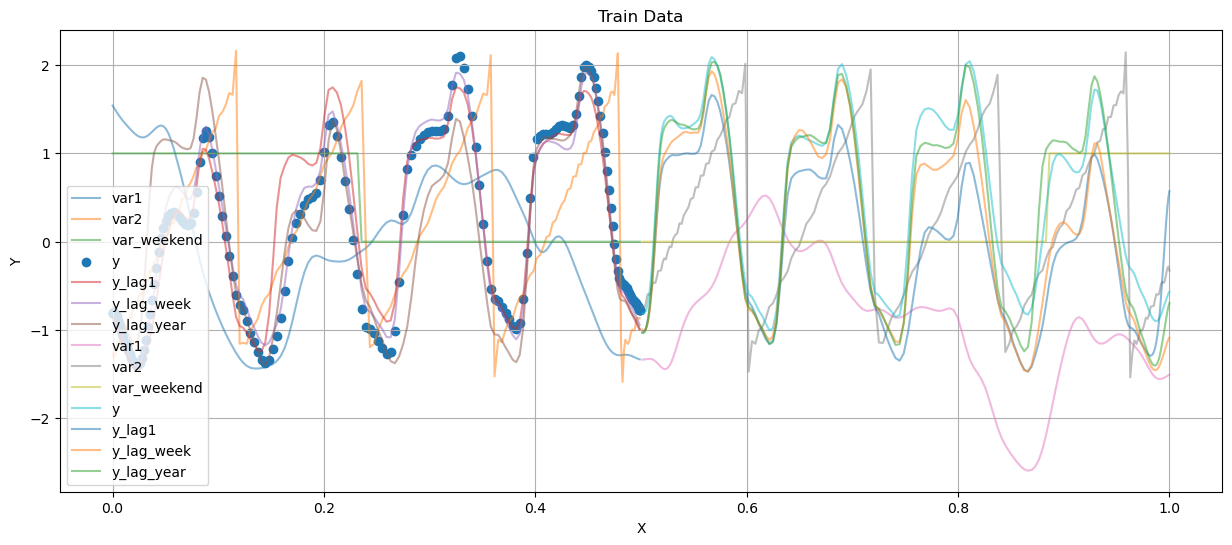

In [4]:
if True:
    plt.figure(figsize=(15, 6))
    for col in df_train.columns.difference(['t']):
        if col == 'y':
            plt.scatter(df_train['t'], df_train[col], label=col, alpha=1)
            continue
        plt.plot(df_train['t'], df_train[col], '-', label=col, alpha=0.5)
        
    for col in df_test.columns.difference(['t']):
        plt.plot(df_test['t'], df_test[col], '-', label=col, alpha=0.5)

    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Train Data')
    plt.grid(True)
    plt.show()

In [5]:
ys = np.atleast_2d(df_train['y']).T
ts = np.array(df_train['t'])
Xs = np.atleast_2d(df_train.drop(columns=['y', 't']))

w = compute_weights(df_train['t'])
Ds = np.array(lagrange_derivative(df_train['t'], w))

In [22]:
importlib.reload(nn_pyomo_base)
NeuralODEPyomo = nn_pyomo_base.NeuralODEPyomo

tol = 1e-8
params = {"tol":tol, 
        "dual_inf_tol": tol, "compl_inf_tol": tol, "constr_viol_tol": tol, 
        "halt_on_ampl_error" : 'yes', "print_level": 5, "max_iter": 500}

layer_sizes = [7, 30, 1]

ode_model = NeuralODEPyomo(y_observed = ys, 
                        t = ts, # t
                        first_derivative_matrix = Ds, # derivative matrix
                        extra_input = Xs, # extra inputs
                        y_init = ys,
                        layer_sizes = layer_sizes, act_func = "tanh", 
                        penalty_lambda_reg = 0.01, 
                        time_invariant = True,
                        w_init_method = 'xavier', 
                        params = params
                        )

ode_model.build_model()
result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

y
Ipopt 3.14.16: tol=1e-08
dual_inf_tol=1e-08
compl_inf_tol=1e-08
constr_viol_tol=1e-08
halt_on_ampl_error=yes
print_level=5
max_iter=500


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    90610
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    52161

Total number of variables............................:      471
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      471
                 

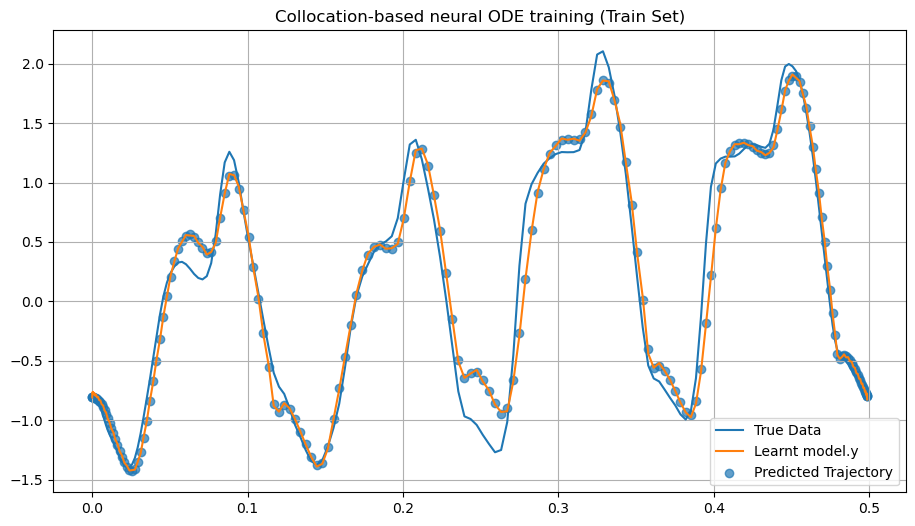

In [36]:
y0 = ys[0]
y_pred = ode_model.neural_ode(y0, ts, (Xs, ts))

plt.figure(figsize=(11, 6))
plt.plot(ts, ys, label='True Data', alpha = 1)
plt.plot(ts, u_model, label='Learnt model.y', alpha = 1)
plt.scatter(ts, y_pred, label='Predicted Trajectory', alpha = 0.7)
plt.title("Collocation-based neural ODE training (Train Set)")
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [17]:
import ode_solver_pyomo_dae
import ode_solver_pyomo_base
import ode_solver_pyomo_opt

In [18]:
trained_weights_biases = ode_model.extract_weights()

W1 = trained_weights_biases['W1']
b1 = trained_weights_biases['b1']
W2 = trained_weights_biases['W2']
b2 = trained_weights_biases['b2']

trained_weights = [W1, W2]
trained_biases = [b1, b2]

In [19]:
# ode_solver_pyomo_opt
importlib.reload(ode_solver_pyomo_opt)
DirectODESolver = ode_solver_pyomo_opt.DirectODESolver

# Define the layer sizes as per your neural network architecture
layer_sizes = [W1.shape[1], W1.shape[0], W2.shape[0]]

tol = 1e-4
params = {"tol":1e-4, 
            "dual_inf_tol": tol, 
            "compl_inf_tol": tol,
            "constr_viol_tol": tol, 
            "acceptable_iter": 0,  
            "halt_on_ampl_error" : 'yes',
            "print_level": 5, 
            "max_iter": 1000 }

initial_state = ys[0][0]
direct_solver = DirectODESolver(np.array(ts), layer_sizes, trained_weights, trained_biases, initial_state, 
                                D = Ds,
                                time_invariant=True, extra_input=np.array(Xs), params = params)

direct_solver.build_model()
solver_info = direct_solver.solve_model()
y_solution = direct_solver.extract_solution()
#t_solution, y_solution = direct_solver.extract_solution()

Ipopt 3.14.16: tol=0.0001
dual_inf_tol=0.0001
compl_inf_tol=0.0001
constr_viol_tol=0.0001
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    20100

Total number of variables............................:      201
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      

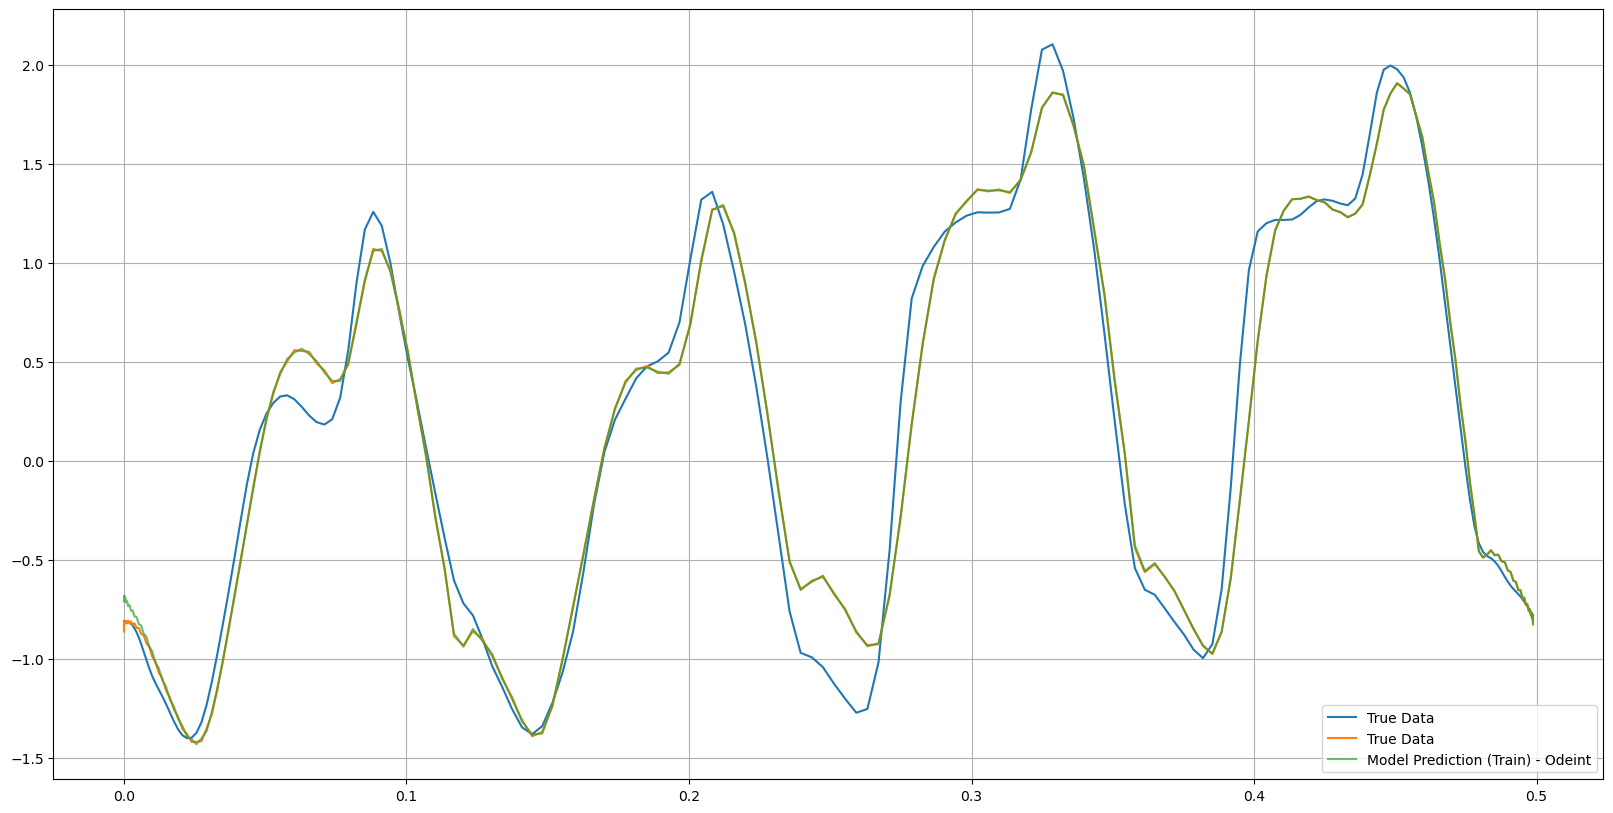

In [20]:
plt.figure(figsize=(20, 10))
plt.plot(ts, ys, label='True Data', alpha = 1)
plt.plot(ts, u_model, label='True Data', alpha = 1)
plt.plot(ts, y_solution, label='Model Prediction (Train) - Odeint', alpha = 0.7)
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

## Test set

In [33]:
ys_test = np.atleast_2d(df_test['y']).T
ts_test = np.array(df_test['t'])
Xs_test = np.atleast_2d(df_test.drop(columns=['y', 't']))

w_test = compute_weights(df_test['t'])
Ds_test = np.array(lagrange_derivative(df_test['t'].values, w_test))

In [34]:
importlib.reload(ode_solver_pyomo_opt)
DirectODESolver = ode_solver_pyomo_opt.DirectODESolver

# Define the layer sizes as per your neural network architecture
layer_sizes = [W1.shape[1], W1.shape[0], W2.shape[0]]

tol = 1e-4
params = {"tol":tol, 
            "dual_inf_tol": tol, 
            "compl_inf_tol": tol,
            "constr_viol_tol": tol, 
            "acceptable_iter": 0,  
            "halt_on_ampl_error" : 'yes',
            "print_level": 5, 
            "max_iter": 1000 }

initial_state = ys_test[0][0]
direct_solver = DirectODESolver(ts_test, layer_sizes, trained_weights, trained_biases, initial_state, 
                                D = Ds_test,
                                time_invariant=True, extra_input=np.array(Xs_test), params = params)

direct_solver.build_model()
solver_info = direct_solver.solve_model()
y_solution = direct_solver.extract_solution()

Ipopt 3.14.16: tol=0.0001
dual_inf_tol=0.0001
compl_inf_tol=0.0001
constr_viol_tol=0.0001
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    20100

Total number of variables............................:      201
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      

In [ ]:
plt.plot(ts, ys, label='True Data', alpha = 1)
plt.plot(ts, u_model, label='Learnt model.y', alpha = 1)
plt.scatter(ts, y_pred, label='Predicted Trajectory', alpha = 0.7)

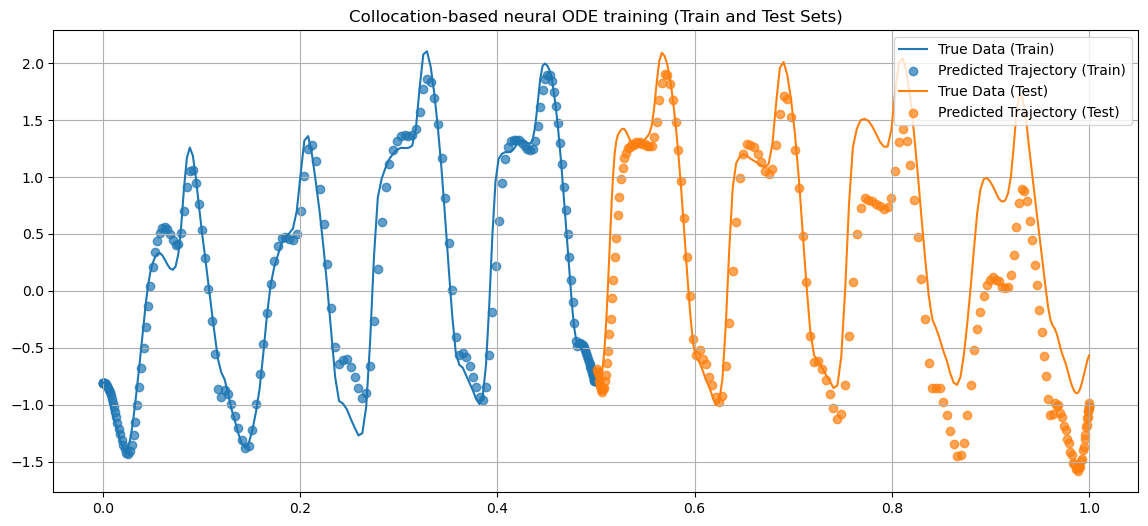

In [59]:
plt.figure(figsize=(14, 6))
plt.plot(ts, ys, label='True Data (Train)', alpha = 1)
#plt.plot(ts, u_model, label='Optimized model.y', alpha = 1)
plt.scatter(ts, y_pred, label='Predicted Trajectory (Train)', alpha = 0.7)
plt.title("Collocation-based neural ODE training (Train Set)")

plt.plot(ts_test, ys_test, label='True Data (Test)', alpha = 1)
plt.scatter(ts_test, y_solution, label='Predicted Trajectory (Test)', alpha = 0.7)
plt.title('Collocation-based neural ODE training (Train and Test Sets)')

plt.legend(loc ="upper right")
plt.grid(True)
plt.show()

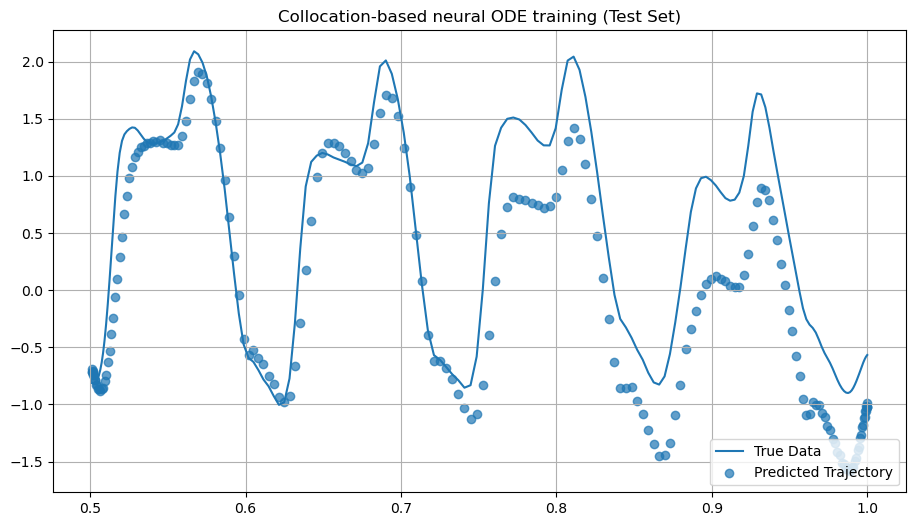

In [50]:
plt.figure(figsize=(11, 6))
plt.plot(ts_test, ys_test, label='True Data', alpha = 1)
plt.scatter(ts_test, y_solution, label='Predicted Trajectory', alpha = 0.7)
plt.title('Collocation-based neural ODE training (Test Set)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()